## Scan of ssd (cut-out)  

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
raw_fpath = '/data02/MyArchive/tomo_datasets/Sigray_SSD/Tekawade_SSD_050.h5'
bumps_data = '/data02/MyArchive/tomo_datasets/Sigray_SSD/bumps_data'
bumps_ply = '/data02/MyArchive/tomo_datasets/Sigray_SSD/bumps.ply'
center = 1616 # see view_full_reconstruction_ssd notebook for how to find center  
pixel_size_um = 0.67
b_K = 8
b = 8

from tomo2mesh.misc import viewer
import tensorflow as tf
from tomo2mesh.misc.rw_dxchange import read_raw_data_any
from tomo2mesh.fbp.subset import recon_all_gpu
from cupyx.scipy.ndimage import gaussian_filter, binary_opening, label
from skimage.filters import threshold_otsu
from utils import Bumps
from tomo2mesh.misc.voxel_processing import modified_autocontrast
from tomo2mesh.fbp.subset import recon_patches_3d
from tomo2mesh.unet3d.surface_segmenter import SurfaceSegmenter
from tomo2mesh.porosity.params_3dunet import *

In [2]:
from tomo2mesh import DataFile
rec_fpath = '/data02/MyArchive/tomo_datasets/Sigray_SSD/reconstructed_gray'
dfile = DataFile(rec_fpath, tiff = True)
vol = dfile.read_full()


##################################################
Found existing tiff folder: reconstructed_gray
Dataset shape: (2304, 3200, 3200)


In [3]:
def midplane_edge_plots(volg, volb, ax, idxs = None):
    img = viewer.get_orthoplanes(vol = volg, idxs = idxs)
    imb = viewer.get_orthoplanes(vol = volb, idxs = idxs)
    for i3 in range(3):
        viewer.edge_plot(img[i3], imb[i3], ax[i3])
    return

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=8196)])
    except RuntimeError as e:
        print(e)

In [5]:
projs, theta, dark, flat = read_raw_data_any(raw_fpath)
ntheta, nz, n = projs.shape
projs = projs[:, :-int(nz%128), :-int(n%128)].copy()
flat = flat[:-int(nz%128), :-int(n%128)].copy()
dark = dark[:-int(nz%128), :-int(n%128)].copy()
print(f"shape of projection data ntheta, nz, n : {projs.shape}")

shape of projection data ntheta, nz, n : (3201, 2304, 3200)


## Coarse Reconstruction  

In [6]:
auto_s = (0.0001, 0.0005) # (0.0001, 0.0001)

In [7]:
V = recon_all_gpu(projs[::b_K,::b,::b], theta[::b_K,...], center/b,\
                  dark_flat = (dark[::b,::b],flat[::b,::b]), \
                  sinogram_order=False)

In [8]:
V_cpu = V.get()

In [9]:
V[:] = gaussian_filter(V,0.5)

In [10]:
voxel_values = V.reshape(-1).get()
thresh = cp.float32(threshold_otsu(voxel_values))    
V[:] = (V>thresh).astype(cp.uint8)    
V[:] = binary_opening(V, structure = cp.ones((9,9,9), dtype = cp.uint8))    

In [11]:
V = cp.array(V, dtype = cp.uint32)
V[:], n_det = label(V,structure = cp.ones((3,3,3),dtype=cp.uint8))    

In [12]:
bumps_b = Bumps().count_voids(V.get(), b, 0, pad_bb = 3)    

	STAT: voids found - 6


In [13]:
x = []
for s in bumps_b["s_voids"]:
    x.append(V_cpu[s].reshape(-1))
voxel_values = np.concatenate(x,axis=0)
rec_min_max = modified_autocontrast(voxel_values, s = auto_s)
thresh_bumps = threshold_otsu(voxel_values)

In [14]:
rec_min_max

(-0.74973506, 1.4855174)

## Reconstruct subset  

In [15]:
# U-net parameters
model_path = '/data02/MyArchive/tomo_datasets/data_porosity_mapping_paper/models_unet'
model_tag = "M_a02"
model_names = {"segmenter" : "segmenter_Unet_%s"%model_tag}

In [16]:
# load the U-net model
model_params = get_model_params(model_tag)
segmenter = SurfaceSegmenter(model_initialization = 'load-model', \
                        model_names = model_names, \
                        model_path = model_path)    


 ####################################################### 


Model is M_a02
n_filters [16, 32]
n_blocks 2
activation lrelu
batch_norm True
isconcat [True, True]
pool_size [2, 4]


In [17]:
grid, r_fac = bumps_b.export_grid(32)

	STAT: 1/r value: 9.78


In [18]:
cp._default_memory_pool.free_all_blocks(); cp.fft.config.get_plan_cache().clear()

In [19]:
x_grid, grid = recon_patches_3d(projs, theta, center, grid, sinogram_order=False, \
                                dark_flat = (dark, flat), \
                                segmenter = segmenter, segmenter_batch_size = 64, \
                                rec_min_max = rec_min_max, outlier_kernel = 3, preblur = True)
x_grid = x_grid^1

100%|███████████████████████████████████████████| 49/49 [04:36<00:00,  5.64s/it]


In [20]:
# x_grid, grid = recon_patches_3d(projs, theta, center, grid, sinogram_order=False, \
#                                 dark_flat = (dark, flat), \
#                                 segmenter = None, outlier_kernel = 3)
# x_grid = (x_grid>thresh_bumps).astype(np.uint8)

In [21]:
cp._default_memory_pool.free_all_blocks(); cp.fft.config.get_plan_cache().clear()
bumps_subset = Bumps().import_from_grid(bumps_b, x_grid, grid, kernel_size = 3)

100%|█████████████████████████████████████████████| 6/6 [00:18<00:00,  3.08s/it]


## Compare with reconstructed grayscale data  

In [22]:
vals = []
x_voids_rec = []
for s in bumps_subset["s_voids"]:
    subvol = vol[s]
    x_voids_rec.append(subvol)
    vals.append(subvol[::4,::4,::4].reshape(-1))
    del subvol
rec_min_max2 = modified_autocontrast(np.concatenate(vals,axis=0), s = auto_s)

In [23]:
for s_void in bumps_subset["s_voids"]:
    x_voids_rec.append(vol[s_void])

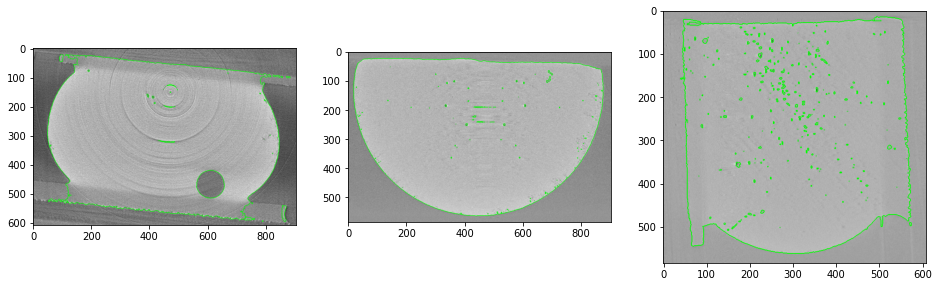

In [24]:
fig, ax = plt.subplots(1,3, figsize = (16,8))
midplane_edge_plots(x_voids_rec[1], bumps_subset["x_voids"][1], ax)

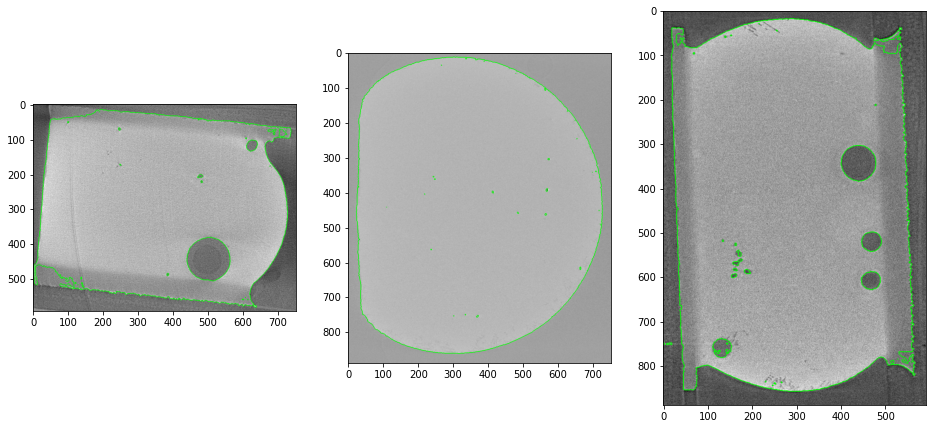

In [25]:
fig, ax = plt.subplots(1,3, figsize = (16,8))
midplane_edge_plots(x_voids_rec[5], bumps_subset["x_voids"][5], ax, idxs = [444,296,360])

In [26]:
np.asarray(bumps_subset["x_voids"][5].shape)//2

array([444, 296, 376])

In [27]:
bumps_subset.write_to_disk(bumps_data)

In [29]:
bumps_subset.export_void_mesh_mproc("sizes", edge_thresh = 4.0, nprocs = 2).write_ply(bumps_ply)

void2mesh_mproc: preserve_feature : False, edge_thres : 4.0, b : 1, nprocs : 2
	TIME: compute void mesh 279.35 secs


##### 